# Reinforcement Learning

# 4. Online control

This notebook presents the **online control** of an agent by SARSA and Q-learning.


In [53]:
import sys
from pathlib import Path

lib_path = str(Path.cwd().parent)

if lib_path not in sys.path:
    sys.path.append(lib_path)
print(sys.path)

['C:\\Python312\\python312.zip', 'C:\\Python312\\DLLs', 'C:\\Python312\\Lib', 'C:\\Python312', 'd:\\Code\\Reinforcement Learning\\venv', '', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\win32', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\win32\\lib', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\Pythonwin', 'd:\\Code\\Reinforcement Learning']


In [54]:
import numpy as np
import matplotlib.pyplot as plt

In [55]:
from lib.model import TicTacToe, Nim, ConnectFour
from lib.agent import Agent, OnlineControl
from lib.dynamic import ValueIteration

## To do

- Complete the class `SARSA` and test it on Tic-Tac-Toe.
- Complete the class `QLearning` and test it on Tic-Tac-Toe.
- Compare these algorithms on Tic-Tac-Toe (play first) and Nim (play second), using a random adversary, then a perfect adversary. Comment your results.
- Test these algorithms on Connect 4 against a random adversary. Comment your results.


## SARSA


In [56]:
class SARSA(OnlineControl):
    """Online control by SARSA."""

    def update_values(self, state=None, horizon=100, epsilon=0.5):
        """Learn the action-value function online."""
        self.model.reset(state)
        state = self.model.state
        if not self.model.is_terminal(state):
            action = self.randomize_best_action(state, epsilon=epsilon)
            for _ in range(horizon):
                code = self.model.encode(state)
                self.action_count[code][action] += 1
                reward, stop = self.model.step(action)
                # to be modified (get sample Avg Gain)
                # begin
                # check if the new state is terminal
                # take new action and get the next state
                next_state = self.model.state
                code_next = self.model.encode(next_state)
                if not stop:
                    next_action = self.randomize_best_action(
                        self.model.state, epsilon=epsilon
                    )
                    gain = (
                        reward + self.gamma * self.action_value[code_next][next_action]
                    )
                else:
                    gain = reward
                # end
                diff = gain - self.action_value[code][action]
                count = self.action_count[code][action]
                self.action_value[code][action] += diff / count
                # to be modified (update state and action)
                # begin
                if stop:
                    break
                state = next_state
                action = next_action
                # end

## Q-learning


In [57]:
class QLearning(OnlineControl):
    """Online control by Q-learning."""

    def update_values(self, state=None, horizon=100, epsilon=0.5):
        """Learn the action-value function online."""
        self.model.reset(state)
        state = self.model.state
        # to be completed
        if not self.model.is_terminal(state):
            for _ in range(horizon):
                action = self.randomize_best_action(state, epsilon=epsilon)

                code = self.model.encode(state)
                self.action_count[code][action] += 1
                reward, stop = self.model.step(action)

                next_state = self.model.state
                if not stop:
                    code_next = self.model.encode(next_state)
                    next_action = self.randomize_best_action(
                        self.model.state, epsilon=0
                    )
                    gain = (
                        reward + self.gamma * self.action_value[code_next][next_action]
                    )
                else:
                    gain = reward

                diff = gain - self.action_value[code][action]
                count = self.action_count[code][action]
                self.action_value[code][action] += diff / count
                if stop:
                    break
                state = next_state

In [58]:
def plot_gains(gains, eps_list, n_games, step, title):
    plt.figure(figsize=(8, 5))
    plt.title(title)
    plt.xlabel("Number of games")
    plt.xticks(
        ticks=np.linspace(0, n_games // step, 6, dtype=int),
        labels=np.linspace(0, n_games - 1, 6, dtype=int),
    )
    plt.ylabel("Gain")
    for i in range(len(eps_list)):
        plt.plot(gains[i], label=f"epsilon = {eps_list[i]}", marker="o")
    plt.legend()
    plt.show()

In [59]:
def run(game, learning_method, eps_list, n_games, step):
    avg_gains = []

    for eps in eps_list:
        algo = learning_method(game)
        gains_list = []

        for i in range(n_games):
            algo.update_values(epsilon=eps)

            if i % step == 0:
                policy = algo.get_policy()
                agent = Agent(game, policy=policy)
                gains = agent.get_gains()
                gains_list.append(np.mean(gains))

        avg_gains.append(gains_list)

    return avg_gains

## To do


### Tic-Tac-Toe


In [60]:
game = TicTacToe()

In [61]:
agent = Agent(game)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  0,  1]), array([39,  9, 52]))

#### Test SARSA on Tic-Tac-Toe vs Random adversary


In [62]:
n_games = 10001
eps_list = [0.05, 0.1, 0.5]
data_points = 10
step = n_games // data_points

avg_gains = run(game, SARSA, eps_list, n_games, step)

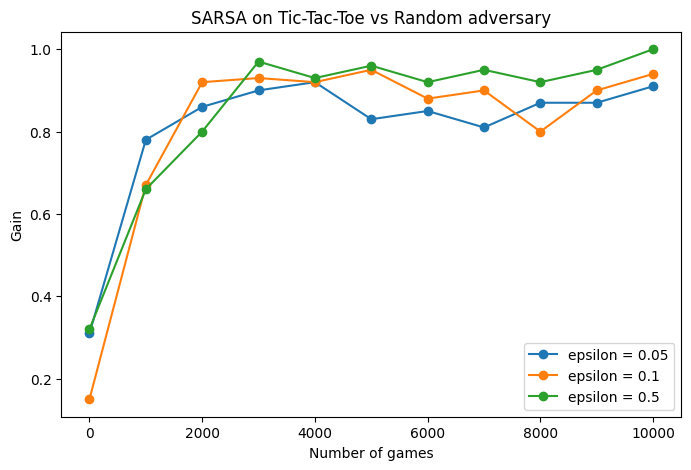

In [63]:
plot_gains(
    avg_gains, eps_list, n_games, step, title="SARSA on Tic-Tac-Toe vs Random adversary"
)

We can see that the gain stabilizes around 0.9.

This is expected as the random adversary is not very strong and the agent can learn to win most of the time.

The choice of epsilon doesn't seem to have a big impact on the learning process.


#### Test Q-learning on Tic-Tac-Toe vs Random adversary


In [64]:
n_games = 10001
eps_list = [0.05, 0.1, 0.5]
data_points = 10
step = n_games // data_points

avg_gains = run(game, QLearning, eps_list, n_games, step)

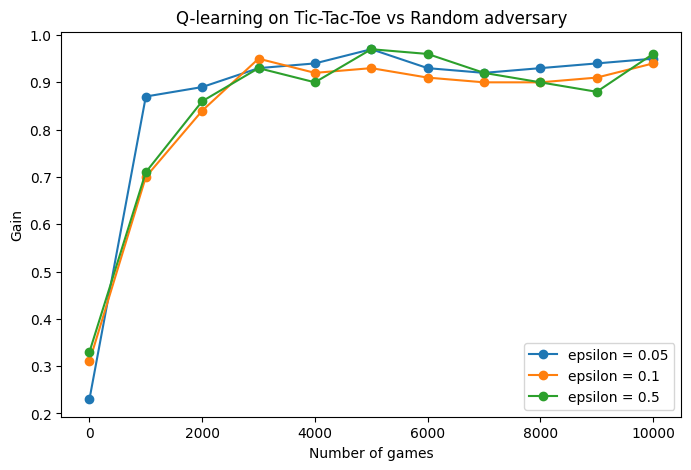

In [65]:
plot_gains(
    avg_gains,
    eps_list,
    n_games,
    step,
    title="Q-learning on Tic-Tac-Toe vs Random adversary",
)

We can see that with Q-learning, the agent learns similarly to SARSA, with a comparable gain at the end.

Again, this is expected as we are playing against a random adversary.

Similarly to SARSA, the choice of epsilon doesn't seem to have a big impact on the learning process.


#### Test SARSA on Tic-Tac-Toe vs perfect adversary


In [66]:
algo = ValueIteration(game)
_, adversary_policy = algo.get_perfect_players()

game = TicTacToe(adversary_policy=adversary_policy)

In [67]:
n_games = 10001
eps_list = [0.05, 0.1, 0.5]
data_points = 10
step = n_games // data_points

avg_gains = run(game, SARSA, eps_list, n_games, step)

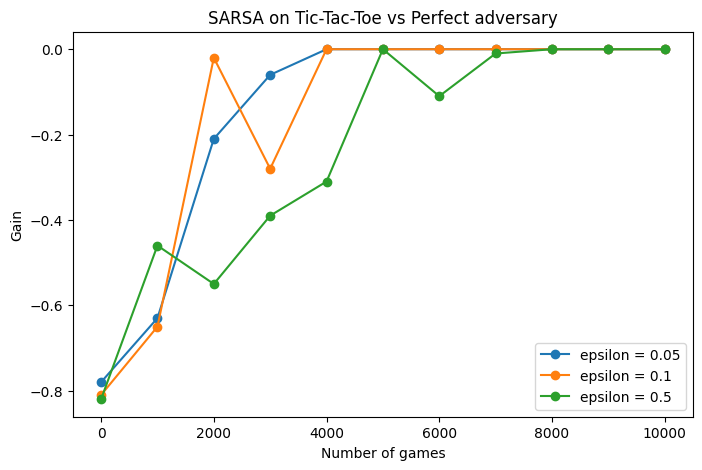

In [68]:
plot_gains(
    avg_gains,
    eps_list,
    n_games,
    step,
    title="SARSA on Tic-Tac-Toe vs Perfect adversary",
)

This time the gain stabilizes around 0.

It is expected as the adversary is perfect and the agent cannot win, even by playing first. The most it can hope for is a draw.


#### Test Q-learning on Tic-Tac-Toe vs perfect adversary


In [69]:
n_games = 10001
eps_list = [0.05, 0.1, 0.5]
data_points = 10
step = n_games // data_points

avg_gains = run(game, QLearning, eps_list, n_games, step)

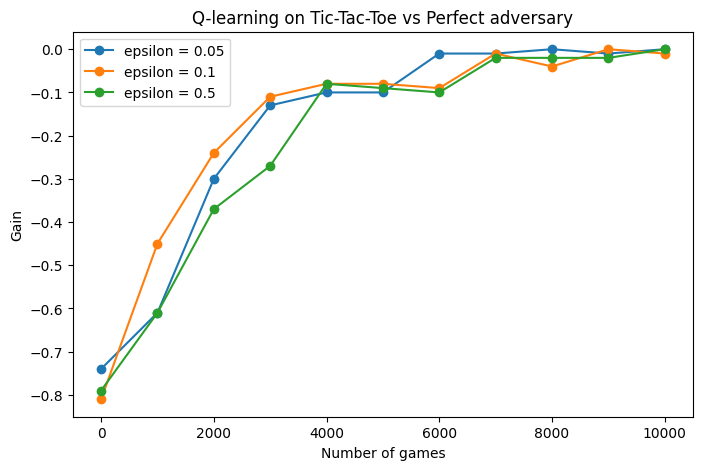

In [70]:
plot_gains(
    avg_gains,
    eps_list,
    n_games,
    step,
    title="Q-learning on Tic-Tac-Toe vs Perfect adversary",
)

Q-learning behaves similarly to SARSA, as expected, but converges slower to a gain of 0.


### Nim


In [71]:
game = Nim(play_first=False)

In [72]:
agent = Agent(game)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([59, 41]))

#### Test SARSA on Nim vs Random adversary


In [73]:
n_games = 10001
eps_list = [0.05, 0.1, 0.5]
data_points = 10
step = n_games // data_points

avg_gains = run(game, SARSA, eps_list, n_games, step)

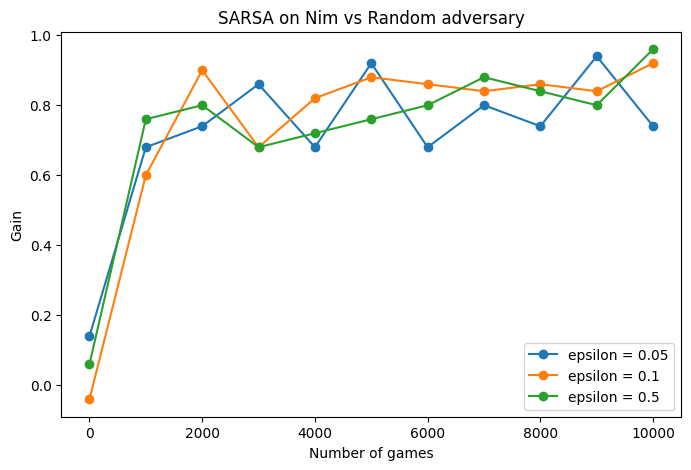

In [74]:
plot_gains(
    avg_gains,
    eps_list,
    n_games,
    step,
    title="SARSA on Nim vs Random adversary",
)

Similarly to Tic-Tac-Toe, the agent learns to win most of the time against a random adversary, but is not able to win all the time.


#### Test Q-learning on Nim vs Random adversary


In [75]:
n_games = 10001
eps_list = [0.05, 0.1, 0.5]
data_points = 10
step = n_games // data_points

avg_gains = run(game, QLearning, eps_list, n_games, step)

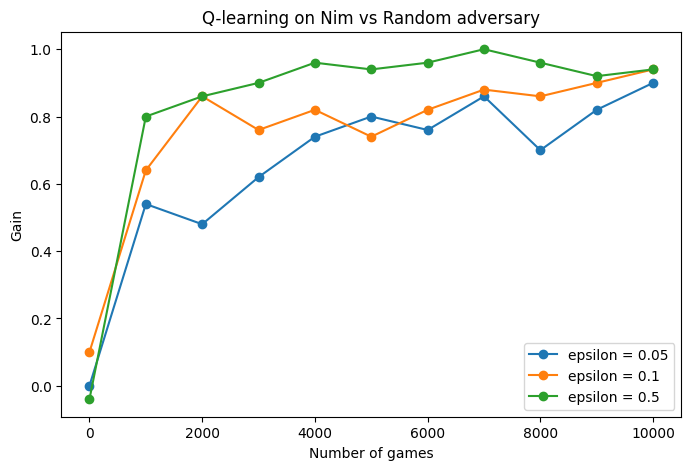

In [76]:
plot_gains(
    avg_gains,
    eps_list,
    n_games,
    step,
    title="Q-learning on Nim vs Random adversary",
)

Q-learning behaves similarly to SARSA, as expected.

Here though, the choice of epsilon seems to have a bigger impact on the learning process.


#### Test SARSA on Nim vs perfect adversary


In [77]:
algo = ValueIteration(game)
_, adversary_policy = algo.get_perfect_players()

game = Nim(adversary_policy=adversary_policy, play_first=False)

In [78]:
n_games = 10001
eps_list = [0.05, 0.1, 0.5]
data_points = 10
step = n_games // data_points

avg_gains = run(game, SARSA, eps_list, n_games, step)

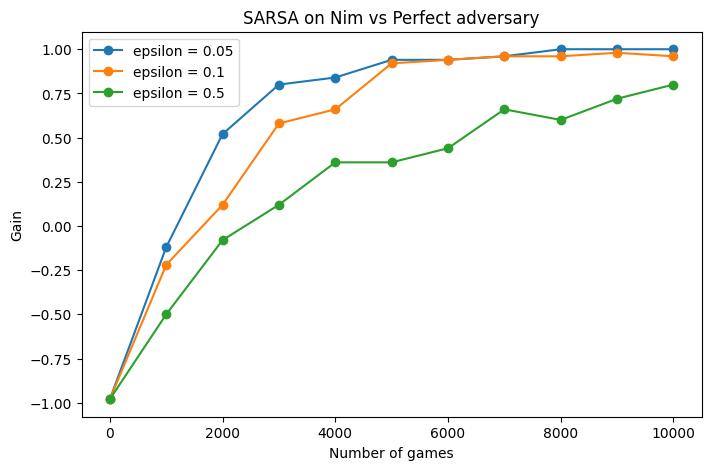

In [79]:
plot_gains(
    avg_gains,
    eps_list,
    n_games,
    step,
    title="SARSA on Nim vs Perfect adversary",
)

Oddly, the agent is able to always win against a perfect adversary.

Analyzing the results, we can see that the agent learns to always win by playing second, which is a known strategy in Nim.
Moreover, the adversary is perfect and deterministic, so the agent can learn to always win by playing second.

Smaller epsilon seems to be better in this case.


#### Test Q-learning on Nim vs perfect adversary


In [80]:
n_games = 10001
eps_list = [0.05, 0.1, 0.5]
data_points = 10
step = n_games // data_points

avg_gains = run(game, QLearning, eps_list, n_games, step)

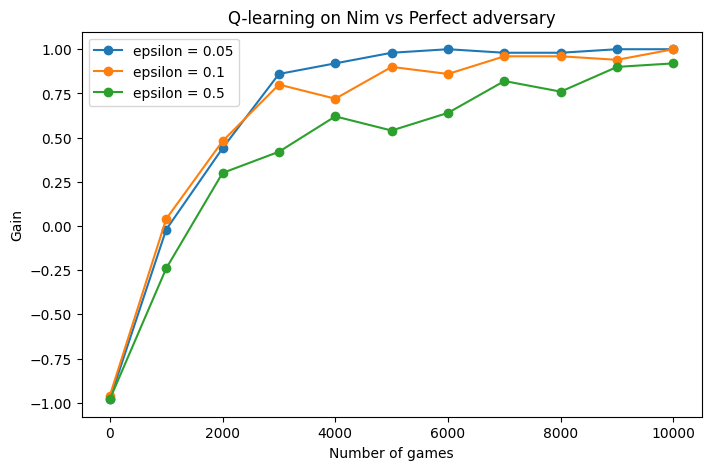

In [81]:
plot_gains(
    avg_gains,
    eps_list,
    n_games,
    step,
    title="Q-learning on Nim vs Perfect adversary",
)

Also with Q-learning, the agent is able to always win against a perfect adversary on Nim, by playing second.

Again, setting a lower epsilon seems to be better.


### Connect Four


In [82]:
game = ConnectFour()

In [83]:
agent = Agent(game)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([50, 50]))

#### Test SARSA on Connect Four vs Random adversary


In [84]:
n_games = 5001
eps_list = [0.05, 0.1, 0.5]
data_points = 10
step = n_games // data_points

avg_gains = run(game, SARSA, eps_list, n_games, step)

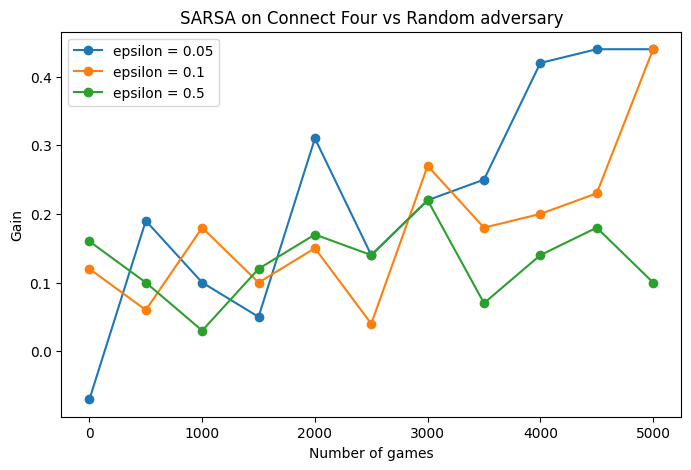

In [85]:
plot_gains(
    avg_gains,
    eps_list,
    n_games,
    step,
    title="SARSA on Connect Four vs Random adversary",
)

We see an increase in the gain over time, but the learning is slow.

This is expected as the state space is much larger than in Tic-Tac-Toe or Nim.


#### Test Q-learning on Connect Four vs Random adversary


In [86]:
n_games = 5001
eps_list = [0.05, 0.1, 0.5]
data_points = 10
step = n_games // data_points

avg_gains = run(game, QLearning, eps_list, n_games, step)

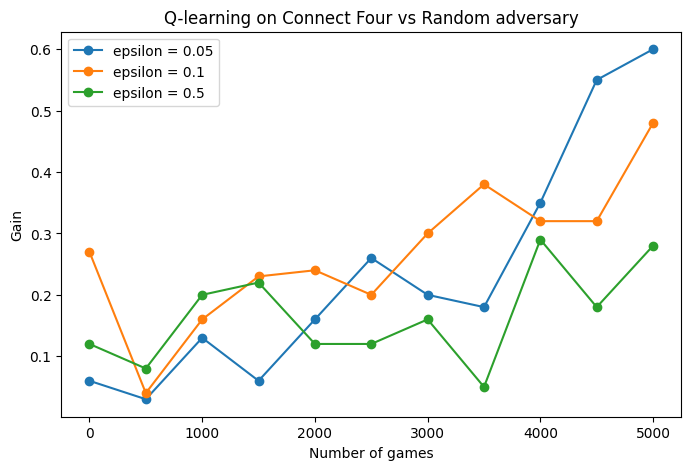

In [87]:
plot_gains(
    avg_gains,
    eps_list,
    n_games,
    step,
    title="Q-learning on Connect Four vs Random adversary",
)

Similarly to SARSA, Q-learning learns slowly against a random adversary, but we can nevertheless see an increase in the gain over time.
